## Evaluation Notebook

### Imports & Config

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from banknote_auth.features import load_clean_data, split_features_targets, scale_features
from banknote_auth.config import MODELS_DIR
from sklearn.model_selection import train_test_split


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)


PROJ_ROOT path is: /Users/peter/banknote-authentication-ml


### Load and Prepare Data

In [2]:
# Load and prepare data
df = load_clean_data()
X, y = split_features_targets(df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale features
X_train_scaled, X_test_scaled = scale_features(X_train, X_test)


2025-07-04 14:24:16.493 | INFO     | banknote_auth.features:load_clean_data:14 - Loading cleaned data from: /Users/peter/banknote-authentication-ml/data/processed/data_cleaned.csv
2025-07-04 14:24:16.522 | INFO     | banknote_auth.features:split_features_targets:20 - Split data into X (shape: (1130, 4)) and y (shape: (1130,))
2025-07-04 14:24:16.530 | INFO     | banknote_auth.features:scale_features:26 - Features scaled with StandardScaler.
2025-07-04 14:24:16.532 | INFO     | banknote_auth.features:scale_features:30 - Scaler saved to: /Users/peter/banknote-authentication-ml/models/scaler.pkl


### Load Model and Predict

In [3]:
model_path = MODELS_DIR / "best_model.pkl"
model = joblib.load(model_path)

y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]


### Accuracy & Classification Report


In [4]:
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00        91

    accuracy                           1.00       226
   macro avg       1.00      1.00      1.00       226
weighted avg       1.00      1.00      1.00       226



### Confusion Matrix

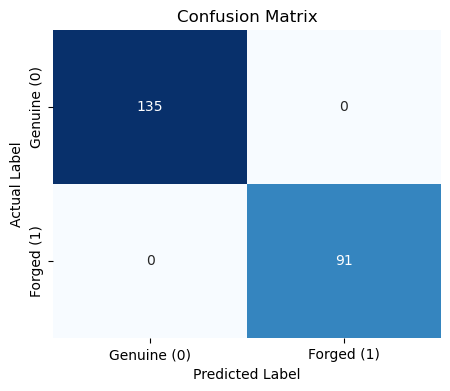

In [5]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
#sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Genuine (0)', 'Forged (1)'],
                yticklabels=['Genuine (0)', 'Forged (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show();


### ROC Curve and AUC

📉 ROC AUC Score: 1.0000


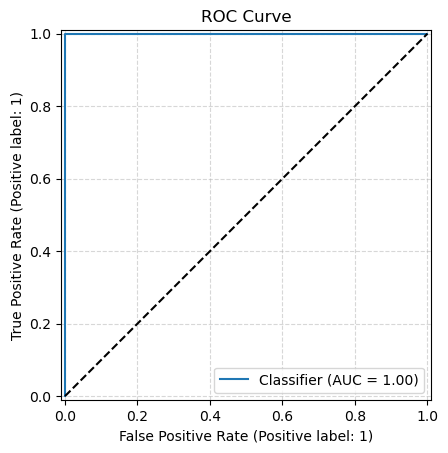

In [6]:
auc = roc_auc_score(y_test, y_proba)
print(f"📉 ROC AUC Score: {auc:.4f}")

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.grid(True, linestyle='--', alpha=0.5)
plt.title("ROC Curve")
plt.show()


### Confusion matrix from the final model:

### Confusion Matrix - reports/figures/confusion_matrix.png

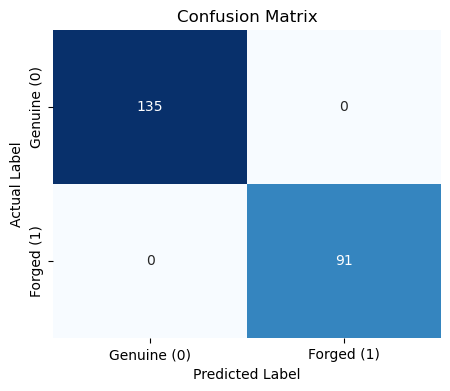

Confusion matrix saved to: /Users/peter/banknote-authentication-ml/notebooks/reports/figures/confusion_matrix.png


In [7]:
import os
from pathlib import Path
import sys
from sklearn.metrics import confusion_matrix

# Assume y_test and y_pred are already defined

# Automatically detect and set the project root
PROJ_ROOT = Path.cwd().resolve()
sys.path.append(str(PROJ_ROOT))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=['Genuine (0)', 'Forged (1)'],
    yticklabels=['Genuine (0)', 'Forged (1)']
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")

# Save to reports/figures/confusion_matrix.png
output_path = PROJ_ROOT / "reports" / "figures" / "confusion_matrix.png"
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to: {output_path}")

### Save Metrics (Accuracy, Classification Report) as Text and JSON

In [8]:
import json

# Calculate evaluation metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

# Prepare output directory
metrics_dir = PROJ_ROOT / "reports" / "metrics"
metrics_dir.mkdir(parents=True, exist_ok=True)

# Save accuracy + full report as .json
with open(metrics_dir / "classification_report.json", "w") as f_json:
    json.dump({"accuracy": acc, "report": report}, f_json, indent=4)

# Save plain text version
with open(metrics_dir / "classification_report.txt", "w") as f_txt:
    f_txt.write(f"Accuracy: {acc:.4f}\n\n")
    f_txt.write(classification_report(y_test, y_pred))

print(f"Metrics saved to: {metrics_dir}")


Metrics saved to: /Users/peter/banknote-authentication-ml/notebooks/reports/metrics


Output on project structure like:

reports/
└── metrics/
    ├── classification_report.json
    └── classification_report.txt


### Automate with a Report Script

Create a Python file: banknote_auth/reporting/generate_report.py

In [9]:
# banknote_auth/reporting/generate_report.py

from banknote_auth.features import load_clean_data, split_features_targets, scale_features
from banknote_auth.config import PROJ_ROOT, MODELS_DIR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

def generate_report():
    df = load_clean_data()
    X, y = split_features_targets(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)

    model = joblib.load(MODELS_DIR / "voting_classifier.pkl")
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # Save metrics
    metrics_dir = PROJ_ROOT / "reports" / "metrics"
    metrics_dir.mkdir(parents=True, exist_ok=True)
    with open(metrics_dir / "classification_report.json", "w") as f_json:
        json.dump({"accuracy": acc, "report": report}, f_json, indent=4)
    with open(metrics_dir / "classification_report.txt", "w") as f_txt:
        f_txt.write(f"Accuracy: {acc:.4f}\n\n")
        f_txt.write(classification_report(y_test, y_pred))

    # Save confusion matrix
    fig_dir = PROJ_ROOT / "reports" / "figures"
    fig_dir.mkdir(parents=True, exist_ok=True)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.savefig(fig_dir / "confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.close()

    print("Report generation complete.")

# Optional export declaration
__all__ = ["generate_report"]

if __name__ == "__main__":
    generate_report()


2025-07-04 14:24:47.255 | INFO     | banknote_auth.features:load_clean_data:14 - Loading cleaned data from: /Users/peter/banknote-authentication-ml/data/processed/data_cleaned.csv
2025-07-04 14:24:47.269 | INFO     | banknote_auth.features:split_features_targets:20 - Split data into X (shape: (1130, 4)) and y (shape: (1130,))
2025-07-04 14:24:47.275 | INFO     | banknote_auth.features:scale_features:26 - Features scaled with StandardScaler.
2025-07-04 14:24:47.277 | INFO     | banknote_auth.features:scale_features:30 - Scaler saved to: /Users/peter/banknote-authentication-ml/models/scaler.pkl


Report generation complete.
